# CNN 1D모델을 사용하여 Sentencepiece, Mecab, 그리고 Okt로 전처리하여 결과 비교

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import wandb
from wandb.keras import WandbCallback
import os
import re
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D

In [2]:
# 데이터 불러오기
train_data_path = os.getenv('HOME') + "/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)

In [3]:
# 클래스 레이블 변경
train_data['class'] = train_data['class'].replace({
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
})

# 중복 제거
train_data = train_data.drop_duplicates('conversation')

# 텍스트 클리닝 함수
def clean_sentence(text):
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\s]', '', text)
    text = text.strip()
    return text

train_data['cleaned_conversation'] = train_data['conversation'].apply(clean_sentence)

# 500자 이상 제거
filtered_df = train_data[train_data['cleaned_conversation'].apply(len) <= 500]

# 불용어 리스트 정의
stop_words = [
    "은", "는", "이", "가", "을", "를", "으로", "에", "에서",
    "하다", "하는", "된", "나", "고", "와", "과", "너무", "있는", "같은", 
    "하는", "것", "그", "그리고", "하는", "하는", "말", "생각", "다", "그런",
    "저", "제", "네", "들", "이다", "입니다", "한다", "합니다", "돼", "이런",
    "저런", "그런", "할", "수z", "있는", "또는", "아니", "합니다", "있다", "왜",
    "여기", "저기", "그렇게", "그러니까", "뭐", "하나", "때", "수", "등", "아주",
    "너", "내", "야", "안", "니", "도"
    # 추가적인 불용어 단어 추가 가능
]

def return_words(corpus):
    # filter stop words
    vect = CountVectorizer(tokenizer=tokenize, stop_words=stopwords, analyzer='word')
    bow_vect = vect.fit_transform(corpus)
    word_list = vect.get_feature_names()  # 어떤 단어들이 들어가있는지 확인
    count_list = bow_vect.toarray().sum(axis=0)  # 인덱스순으로 몇개의 단어가 있는지
    word_count_dict = dict(zip(word_list, count_list))  # word, count를 key value로 묶는 것

    # 빈도수가 높은 순으로 정렬
    sorted_word_count = sorted(word_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    print(sorted_word_count)


# SentencePiece

In [4]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    # Train SentencePiece tokenizer
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    # Load tokenizer
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

In [5]:
sentence_train = filtered_df['cleaned_conversation']
y_train = filtered_df['class']

VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(sentence_train, VOCAB_SIZE)

# 토크나이징
tokenized_sentences = [tokenizer.encode_as_ids(sentence) for sentence in sentence_train]

# 패딩처리
padding_train = pad_sequences(tokenized_sentences, maxlen=500, padding='post')

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(padding_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(padding_train)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=20000 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

(3000, 500) (3000,)
(750, 500) (750,)
[[   25     5  2775 ...     0     0     0]
 [13158   281   610 ...     0     0     0]
 [    5   908 17289 ...     0     0     0]
 ...
 [  124   267   261 ...     0     0     0]
 [ 9990   271 10732 ...     0     0     0]
 [ 4871     8   550 ...     0     0     0]]


In [6]:
# 모델 파라미터 설정
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256

# 1D CNN 모델 구성
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 256)          12800000  
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 128)          163968    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 12,972,484
Trainable params: 12,972,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 5s 17ms/step - loss: 1.1827 - accuracy: 0.4830 - val_loss:

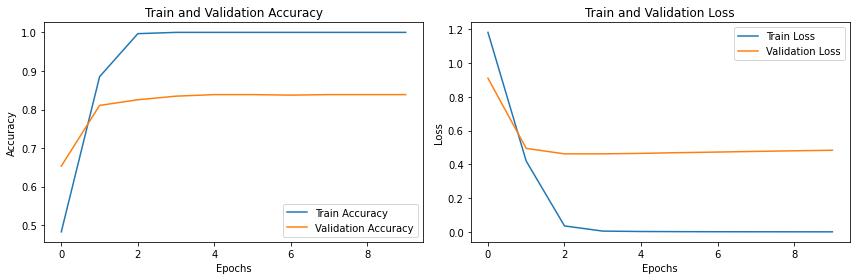

In [7]:
# 정확도에 대한 그래프
plt.figure(figsize=(12, 4))

# 학습 및 검증 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실에 대한 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
test_data_path ="~/data/test.json"
test = pd.read_json(test_data_path)
test = test.T
test

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...
...,...
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [9]:
test['cleaned_conversation'] = test['text'].apply(clean_sentence)
filtered_test=test
test_sentence = filtered_test['cleaned_conversation']

In [10]:
# 패딩처리
padding_test = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in test_sentence],
    padding='post'
)
prediction = model.predict(padding_test)
prediction
predicted_labels = np.argmax(prediction, axis=1)

In [13]:
from os.path import join

data_dir = os.getenv('HOME')+'/aiffel/dktc/data'

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN


In [14]:
submission['class'] = predicted_labels
submission.head()

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_004,3
4,t_005,0


In [15]:
file_path = "/aiffel/submission_sp.csv"

# Save the DataFrame to a CSV file
submission.to_csv(file_path, index=False) 

# Mecab

/tmp/ipykernel_10062/3254917968.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tokenized_conversation'] = filtered_df['cleaned_conversation'].apply(mecab_tokenize)
/tmp/ipykernel_10062/3254917968.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['joined_tokens'] = filtered_df['tokenized_conversation'].apply(lambda x: ' '.join(x))


(3000, 500) (3000,)
(750, 500) (750,)
[[   25  2775   638 ...     0     0     0]
 [  832  3493   610 ...     0     0     0]
 [  908  8969    48 ...     0     0     0]
 ...
 [  267  1536   133 ...     0     0     0]
 [  365  2011     4 ...     0     0     0]
 [11147  1972   267 ...     0     0     0]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 256)          12800000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          163968    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense) 

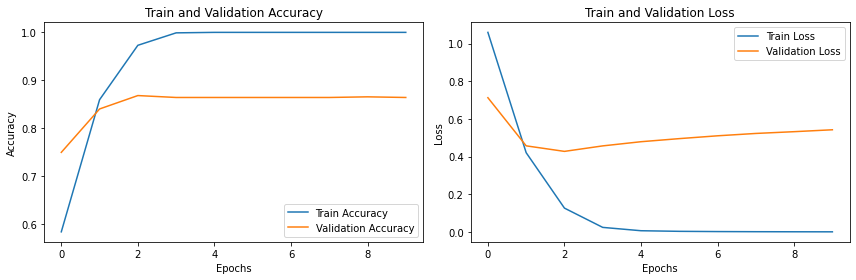

In [16]:
from konlpy.tag import Mecab

# Mecab 초기화
mecab = Mecab()

def mecab_tokenize(corpus):
    return [word for word in mecab.morphs(corpus) if word not in stop_words]


# 데이터 토큰화
filtered_df['tokenized_conversation'] = filtered_df['cleaned_conversation'].apply(mecab_tokenize)
filtered_df['joined_tokens'] = filtered_df['tokenized_conversation'].apply(lambda x: ' '.join(x))

# 데이터와 레이블 설정
sentence_train = filtered_df['joined_tokens']
y_train = filtered_df['class']

# 토크나이징
tokenized_sentences = [tokenizer.encode_as_ids(sentence) for sentence in sentence_train]

# 패딩처리
padding_train = pad_sequences(tokenized_sentences, maxlen=500, padding='post')

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(padding_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(padding_train)

# 모델 파라미터 설정
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256

# 1D CNN 모델 구성
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# 결과 시각화 (정확도 및 손실)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test['cleaned_conversation'] = test['text'].apply(clean_sentence)

filtered_test=test

test_sentence = filtered_test['cleaned_conversation']

# 패딩처리
padding_test = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in test_sentence],
    padding='post'
)
prediction = model.predict(padding_test)
prediction
predicted_labels = np.argmax(prediction, axis=1)

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN


In [18]:
submission['class'] = predicted_labels
submission.head()

,file_name,class
0,t_000,1
1,t_001,3
2,t_002,3
3,t_004,3
4,t_005,0


In [19]:
file_path = "/aiffel/submission_mecab.csv"

# Save the DataFrame to a CSV file
submission.to_csv(file_path, index=False) 

# OKT

/tmp/ipykernel_10062/891791395.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tokenized_conversation'] = filtered_df['cleaned_conversation'].apply(okt_tokenize)
/tmp/ipykernel_10062/891791395.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['joined_tokens'] = filtered_df['tokenized_conversation'].apply(lambda x: ' '.join(x))


(3000, 500) (3000,)
(750, 500) (750,)
[[   25  2775   638 ...     0     0     0]
 [  832  3493   610 ...     0     0     0]
 [  908 17289   449 ...     0     0     0]
 ...
 [  267   133   548 ...     0     0     0]
 [  365  2011     4 ...     0     0     0]
 [11147     4 17686 ...     0     0     0]]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 256)          12800000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 128)          163968    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense) 

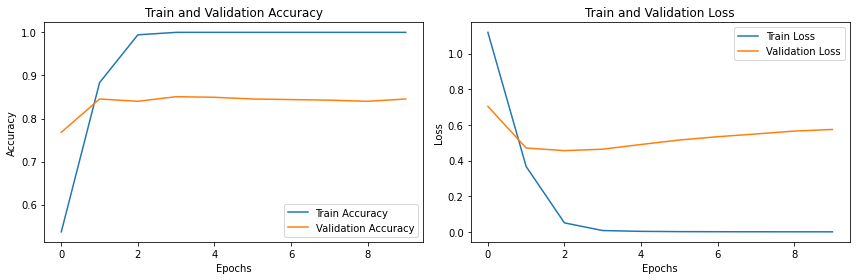

In [20]:
from konlpy.tag import Okt

# Okt 초기화
okt = Okt()

def okt_tokenize(corpus):
    return [word for word in okt.morphs(corpus) if word not in stop_words]

# 데이터 토큰화
filtered_df['tokenized_conversation'] = filtered_df['cleaned_conversation'].apply(okt_tokenize)
filtered_df['joined_tokens'] = filtered_df['tokenized_conversation'].apply(lambda x: ' '.join(x))

# 데이터와 레이블 설정
sentence_train = filtered_df['joined_tokens']
y_train = filtered_df['class']

# 토크나이징
tokenized_sentences = [tokenizer.encode_as_ids(sentence) for sentence in sentence_train]

# 패딩처리
padding_train = pad_sequences(tokenized_sentences, maxlen=500, padding='post')

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(padding_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(padding_train)

# 모델 파라미터 설정
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256

# 1D CNN 모델 구성
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# 결과 시각화 (정확도 및 손실)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
test['cleaned_conversation'] = test['text'].apply(clean_sentence)

In [26]:
filtered_test=test
filtered_test

,text,cleaned_conversation
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,아가씨 담배한갑주소 네 원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,우리팀에서 다른팀으로 갈 사람 없나 그럼 영지씨가 가는건 어때 네 제가요 그렇지 ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요 제대로 좀 하지 네 똑바로 좀 하지 행실...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,아무튼 앞으로 니가 내 와이파이야 응 와이파이 온 켰어 반말 주인님이라고도 말해야지...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...,그러니까 빨리 말해 선생님 제발 살려주십시오 비밀번호 틀릴 때마다 손톱 하나씩 뺀...
...,...,...
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요 네 합니다 보고서를 ...
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,교수님 제 논문에 제 이름이 없나요 아 무슨 논문말이야 지난 번 냈던 논문이요 ...
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,야 너 네 저요 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,야 너 빨리 안 뛰어와 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다가...


In [27]:
test_sentence = filtered_test['cleaned_conversation']

In [29]:
prediction = model.predict(padding_test)
prediction

array([[7.4765056e-02, 6.6911054e-01, 1.5568705e-03, 2.5456753e-01],
       [5.6946301e-03, 1.3696840e-05, 9.8947829e-01, 4.8133396e-03],
       [3.8582344e-02, 1.0943473e-02, 3.9192548e-01, 5.5854869e-01],
       ...,
       [1.3971037e-05, 9.9998367e-01, 3.3432013e-08, 2.3712569e-06],
       [8.0344093e-01, 3.1988521e-04, 1.6083652e-01, 3.5402600e-02],
       [2.3813325e-01, 7.4740624e-01, 5.3952914e-03, 9.0653030e-03]],
      dtype=float32)

In [30]:
predicted_labels = np.argmax(prediction, axis=1)

In [28]:
# 패딩처리
padding_test = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in test_sentence],
    padding='post'
)

In [32]:
submission['class'] = predicted_labels
submission.head()

file_path = "/aiffel/submission_okt.csv"

# Save the DataFrame to a CSV file
submission.to_csv(file_path, index=False) 

In [21]:
wandb.login(key = '5dc8d67fbbb38643e6c0b3fa911c6fea399c3019')

wandb: Currently logged in as: bitna3192 (aiffelnlp). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [22]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [33]:
def train():
    default_config = {
        "vocab" : 1000,
        "embeddings" : 64,
        "units_1" : 128,
        "units_2" : 128,
        "units_3" : 32,
        "class_num" : 4,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 10,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    # 모델 파라미터 설정
    MAX_NB_WORDS = 50000
    MAX_SEQUENCE_LENGTH = 500
    EMBEDDING_DIM = 256

    # 1D CNN 모델 구성
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    # 모델 컴파일
    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)

    model.compile(optimizer=optimizer,
                  loss=config.loss,
                  metrics=config.metrics)

    # WandbCallback 함수는 후술합니다.
    model.fit(X_train, y_train,
              epochs=config.epoch,
              batch_size=config.batch_size,
              validation_data=(X_val, y_val),
              callbacks=[WandbCallback()])

    test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)

    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    wandb.log({"Test Accuracy Rate: ": round(test_accuracy * 100, 2),
               "Test Error Rate: ": round((1 - test_accuracy) * 100, 2)})

In [34]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "bitna3192",
                       project = "DLThon")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: 7f3b18ju
Sweep URL: https://wandb.ai/bitna3192/DLThon/sweeps/7f3b18ju


wandb: Agent Starting Run: uyst4s4r with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.061830749806622634


Epoch 1/9
94/94 [==============================] - 2s 16ms/step - loss: 1.5304 - accuracy: 0.3493 - val_loss: 1.3677 - val_accuracy: 0.2720
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_222926-uyst4s4r/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_222926-uyst4s4r/files/model-best)... Done. 1.6s


Epoch 2/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3936 - accuracy: 0.2633 - val_loss: 1.3866 - val_accuracy: 0.2493
Epoch 3/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3888 - accuracy: 0.2520 - val_loss: 1.3895 - val_accuracy: 0.2600
Epoch 4/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3897 - accuracy: 0.2603 - val_loss: 1.3898 - val_accuracy: 0.2600
Epoch 5/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3924 - accuracy: 0.2347 - val_loss: 1.3893 - val_accuracy: 0.2560
Epoch 6/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3887 - accuracy: 0.2523 - val_loss: 1.3894 - val_accuracy: 0.2347
Epoch 7/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3893 - accuracy: 0.2643 - val_loss: 1.3889 - val_accuracy: 0.2600
Epoch 8/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3903 - accuracy: 0.2557 - val_loss: 1.3929 - val_accuracy: 0.2560
Epoch 9/9
94/94 [===

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▃▂▃▁▂▃▂▂
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▁▁▁▁▁▁▁
val_accuracy,█▄▆▆▅▁▆▅▆
val_loss,▁▆▇▇▇▇▇█▆
Test Accuracy Rate:,26.0
Test Error Rate:,74.0
accuracy,0.24967
best_epoch,0


wandb: Agent Starting Run: sdxu7pz4 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.02355391863651369


Epoch 1/10
94/94 [==============================] - 2s 16ms/step - loss: 0.8425 - accuracy: 0.6863 - val_loss: 0.7713 - val_accuracy: 0.7653
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_222952-sdxu7pz4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_222952-sdxu7pz4/files/model-best)... Done. 1.8s


Epoch 2/10
94/94 [==============================] - 1s 15ms/step - loss: 0.4665 - accuracy: 0.8493 - val_loss: 0.6805 - val_accuracy: 0.7813
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_222952-sdxu7pz4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_222952-sdxu7pz4/files/model-best)... Done. 1.8s


Epoch 3/10
94/94 [==============================] - 1s 15ms/step - loss: 0.5225 - accuracy: 0.8320 - val_loss: 1.1157 - val_accuracy: 0.7293
Epoch 4/10
94/94 [==============================] - 1s 14ms/step - loss: 0.8324 - accuracy: 0.6913 - val_loss: 1.3837 - val_accuracy: 0.4533
Epoch 5/10
94/94 [==============================] - 1s 14ms/step - loss: 1.0983 - accuracy: 0.5283 - val_loss: 1.5705 - val_accuracy: 0.4947
Epoch 6/10
94/94 [==============================] - 1s 14ms/step - loss: 0.9944 - accuracy: 0.5500 - val_loss: 1.3574 - val_accuracy: 0.3813
Epoch 7/10
94/94 [==============================] - 1s 14ms/step - loss: 1.1345 - accuracy: 0.4117 - val_loss: 2.0067 - val_accuracy: 0.3893
Epoch 8/10
94/94 [==============================] - 1s 14ms/step - loss: 1.3042 - accuracy: 0.3310 - val_loss: 2.1870 - val_accuracy: 0.3413
Epoch 9/10
94/94 [==============================] - 1s 14ms/step - loss: 1.3813 - accuracy: 0.2663 - val_loss: 1.3889 - val_accuracy: 0.2600
Epoch 10/10
9

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▆██▆▄▅▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▄▁▁▄▆▅▆▇██
val_accuracy,██▇▄▄▃▃▂▁▁
val_loss,▁▁▃▄▅▄▇█▄▄
Test Accuracy Rate:,25.6
Test Error Rate:,74.4
accuracy,0.25033
best_epoch,1


wandb: Agent Starting Run: eigsb4ez with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.06734700604452647


Epoch 1/7
94/94 [==============================] - 2s 16ms/step - loss: 1.5749 - accuracy: 0.3190 - val_loss: 1.3880 - val_accuracy: 0.2627
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223044-eigsb4ez/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223044-eigsb4ez/files/model-best)... Done. 1.9s


Epoch 2/7
94/94 [==============================] - 1s 15ms/step - loss: 1.3872 - accuracy: 0.2587 - val_loss: 1.3866 - val_accuracy: 0.2493
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223044-eigsb4ez/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223044-eigsb4ez/files/model-best)... Done. 1.8s


Epoch 3/7
94/94 [==============================] - 1s 15ms/step - loss: 1.3853 - accuracy: 0.2577 - val_loss: 1.3943 - val_accuracy: 0.2493
Epoch 4/7
94/94 [==============================] - 1s 14ms/step - loss: 1.3823 - accuracy: 0.2590 - val_loss: 1.5446 - val_accuracy: 0.2680
Epoch 5/7
94/94 [==============================] - 1s 14ms/step - loss: 1.6519 - accuracy: 0.2620 - val_loss: 1.3879 - val_accuracy: 0.2493
Epoch 6/7
94/94 [==============================] - 1s 15ms/step - loss: 1.3902 - accuracy: 0.2437 - val_loss: 1.3892 - val_accuracy: 0.2560
Epoch 7/7
94/94 [==============================] - 1s 14ms/step - loss: 1.3896 - accuracy: 0.2490 - val_loss: 1.3892 - val_accuracy: 0.2560
24/24 - 0s - loss: 1.3892 - accuracy: 0.2560


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▂▂▂▃▁▁
epoch,▁▂▃▅▆▇█
loss,▆▁▁▁█▁▁
val_accuracy,▆▁▁█▁▄▄
val_loss,▁▁▁█▁▁▁
Test Accuracy Rate:,25.6
Test Error Rate:,74.4
accuracy,0.249
best_epoch,1


wandb: Agent Starting Run: pnxuuwrg with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.08448898401751691


Epoch 1/9
94/94 [==============================] - 2s 17ms/step - loss: 1.9541 - accuracy: 0.2663 - val_loss: 1.3916 - val_accuracy: 0.2560
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best)... Done. 1.7s


Epoch 2/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3879 - accuracy: 0.2677 - val_loss: 1.3942 - val_accuracy: 0.2493
Epoch 3/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3895 - accuracy: 0.2590 - val_loss: 1.3911 - val_accuracy: 0.2600
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best)... Done. 1.8s


Epoch 4/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3896 - accuracy: 0.2517 - val_loss: 1.3898 - val_accuracy: 0.2493
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best)... Done. 1.7s


Epoch 5/9
94/94 [==============================] - 1s 16ms/step - loss: 1.3914 - accuracy: 0.2523 - val_loss: 1.3913 - val_accuracy: 0.2493
Epoch 6/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3943 - accuracy: 0.2390 - val_loss: 1.3922 - val_accuracy: 0.2560
Epoch 7/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3901 - accuracy: 0.2617 - val_loss: 1.3866 - val_accuracy: 0.2493
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best)... Done. 1.6s


Epoch 8/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3896 - accuracy: 0.2640 - val_loss: 1.3861 - val_accuracy: 0.2600
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223118-pnxuuwrg/files/model-best)... Done. 3.8s


Epoch 9/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3903 - accuracy: 0.2630 - val_loss: 1.3875 - val_accuracy: 0.2560
24/24 - 0s - loss: 1.3875 - accuracy: 0.2560


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,██▆▄▄▁▇▇▇
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▁▁▁▁▁▁▁
val_accuracy,▅▁█▁▁▅▁█▅
val_loss,▆█▅▄▅▆▁▁▂
Test Accuracy Rate:,25.6
Test Error Rate:,74.4
accuracy,0.263
best_epoch,7


wandb: Agent Starting Run: bzxe4zk2 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.002109164209869849


Epoch 1/7
94/94 [==============================] - 2s 16ms/step - loss: 0.8425 - accuracy: 0.6723 - val_loss: 0.4896 - val_accuracy: 0.8320
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223209-bzxe4zk2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223209-bzxe4zk2/files/model-best)... Done. 1.7s


Epoch 2/7
94/94 [==============================] - 1s 15ms/step - loss: 0.1792 - accuracy: 0.9417 - val_loss: 0.5064 - val_accuracy: 0.8373
Epoch 3/7
94/94 [==============================] - 1s 14ms/step - loss: 0.0120 - accuracy: 0.9993 - val_loss: 0.4591 - val_accuracy: 0.8453
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223209-bzxe4zk2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223209-bzxe4zk2/files/model-best)... Done. 2.4s


Epoch 4/7
94/94 [==============================] - 1s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4725 - val_accuracy: 0.8533
Epoch 5/7
94/94 [==============================] - 1s 14ms/step - loss: 7.2910e-04 - accuracy: 1.0000 - val_loss: 0.4827 - val_accuracy: 0.8547
Epoch 6/7
94/94 [==============================] - 1s 14ms/step - loss: 4.9889e-04 - accuracy: 1.0000 - val_loss: 0.4906 - val_accuracy: 0.8560
Epoch 7/7
94/94 [==============================] - 1s 14ms/step - loss: 3.6682e-04 - accuracy: 1.0000 - val_loss: 0.4989 - val_accuracy: 0.8560
24/24 - 0s - loss: 0.4989 - accuracy: 0.8560


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▇█████
epoch,▁▂▃▅▆▇█
loss,█▂▁▁▁▁▁
val_accuracy,▁▃▅▇███
val_loss,▆█▁▃▄▆▇
Test Accuracy Rate:,85.6
Test Error Rate:,14.4
accuracy,1.0
best_epoch,2


wandb: Agent Starting Run: m8izz2ot with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.08764873022760944


Epoch 1/6
94/94 [==============================] - 2s 16ms/step - loss: 1.7833 - accuracy: 0.2620 - val_loss: 1.3866 - val_accuracy: 0.2560
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223240-m8izz2ot/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223240-m8izz2ot/files/model-best)... Done. 1.6s


Epoch 2/6
94/94 [==============================] - 1s 15ms/step - loss: 1.3923 - accuracy: 0.2453 - val_loss: 1.3882 - val_accuracy: 0.2560
Epoch 3/6
94/94 [==============================] - 1s 14ms/step - loss: 1.3911 - accuracy: 0.2607 - val_loss: 1.3918 - val_accuracy: 0.2560
Epoch 4/6
94/94 [==============================] - 1s 14ms/step - loss: 1.3894 - accuracy: 0.2547 - val_loss: 1.3864 - val_accuracy: 0.2600
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223240-m8izz2ot/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223240-m8izz2ot/files/model-best)... Done. 2.3s


Epoch 5/6
94/94 [==============================] - 1s 15ms/step - loss: 1.3908 - accuracy: 0.2460 - val_loss: 1.3880 - val_accuracy: 0.2600
Epoch 6/6
94/94 [==============================] - 1s 15ms/step - loss: 1.3920 - accuracy: 0.2520 - val_loss: 1.3861 - val_accuracy: 0.2560
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223240-m8izz2ot/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223240-m8izz2ot/files/model-best)... Done. 2.3s


24/24 - 0s - loss: 1.3861 - accuracy: 0.2560


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▁▇▅▁▄
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
val_accuracy,▁▁▁██▁
val_loss,▂▄█▁▃▁
Test Accuracy Rate:,25.6
Test Error Rate:,74.4
accuracy,0.252
best_epoch,5


wandb: Agent Starting Run: mo6j2ikp with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.05249454691935406


Epoch 1/5
94/94 [==============================] - 2s 16ms/step - loss: 1.5250 - accuracy: 0.3503 - val_loss: 1.3170 - val_accuracy: 0.3640
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223315-mo6j2ikp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223315-mo6j2ikp/files/model-best)... Done. 1.8s


Epoch 2/5
94/94 [==============================] - 1s 16ms/step - loss: 1.3811 - accuracy: 0.2813 - val_loss: 1.3952 - val_accuracy: 0.2560
Epoch 3/5
94/94 [==============================] - 1s 14ms/step - loss: 1.3904 - accuracy: 0.2520 - val_loss: 1.3871 - val_accuracy: 0.2493
Epoch 4/5
94/94 [==============================] - 1s 14ms/step - loss: 1.3899 - accuracy: 0.2470 - val_loss: 1.3857 - val_accuracy: 0.2493
Epoch 5/5
94/94 [==============================] - 1s 14ms/step - loss: 1.3882 - accuracy: 0.2500 - val_loss: 1.3867 - val_accuracy: 0.2560
24/24 - 0s - loss: 1.3867 - accuracy: 0.2560


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▃▁▁▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,█▁▁▁▁
val_loss,▁█▇▇▇
Test Accuracy Rate:,25.6
Test Error Rate:,74.4
accuracy,0.25
best_epoch,0


wandb: Agent Starting Run: dy8vytkr with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.02204966904977713


Epoch 1/6
94/94 [==============================] - 2s 17ms/step - loss: 0.8517 - accuracy: 0.6837 - val_loss: 0.6973 - val_accuracy: 0.7253
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223336-dy8vytkr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223336-dy8vytkr/files/model-best)... Done. 2.1s


Epoch 2/6
94/94 [==============================] - 1s 15ms/step - loss: 0.4226 - accuracy: 0.8643 - val_loss: 0.6671 - val_accuracy: 0.7720
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223336-dy8vytkr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223336-dy8vytkr/files/model-best)... Done. 1.7s


Epoch 3/6
94/94 [==============================] - 1s 15ms/step - loss: 0.4117 - accuracy: 0.8920 - val_loss: 0.9367 - val_accuracy: 0.6067
Epoch 4/6
94/94 [==============================] - 1s 15ms/step - loss: 0.5867 - accuracy: 0.7900 - val_loss: 1.1903 - val_accuracy: 0.7413
Epoch 5/6
94/94 [==============================] - 1s 14ms/step - loss: 0.5685 - accuracy: 0.8073 - val_loss: 1.4333 - val_accuracy: 0.5853
Epoch 6/6
94/94 [==============================] - 1s 14ms/step - loss: 1.0453 - accuracy: 0.5280 - val_loss: 1.4238 - val_accuracy: 0.3200
24/24 - 0s - loss: 1.4238 - accuracy: 0.3200


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▄▇█▆▆▁
epoch,▁▂▄▅▇█
loss,▆▁▁▃▃█
val_accuracy,▇█▅█▅▁
val_loss,▁▁▃▆██
Test Accuracy Rate:,32.0
Test Error Rate:,68.0
accuracy,0.528
best_epoch,1


wandb: Agent Starting Run: jqozdnfm with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.012832876149654789


Epoch 1/6
94/94 [==============================] - 2s 21ms/step - loss: 0.7237 - accuracy: 0.7140 - val_loss: 0.6731 - val_accuracy: 0.7640
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223406-jqozdnfm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223406-jqozdnfm/files/model-best)... Done. 1.6s


Epoch 2/6
94/94 [==============================] - 1s 16ms/step - loss: 0.2235 - accuracy: 0.9293 - val_loss: 1.1666 - val_accuracy: 0.7360
Epoch 3/6
94/94 [==============================] - 1s 15ms/step - loss: 0.0961 - accuracy: 0.9673 - val_loss: 0.6426 - val_accuracy: 0.8347
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223406-jqozdnfm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223406-jqozdnfm/files/model-best)... Done. 1.5s


Epoch 4/6
94/94 [==============================] - 1s 15ms/step - loss: 0.0793 - accuracy: 0.9740 - val_loss: 1.0162 - val_accuracy: 0.8053
Epoch 5/6
94/94 [==============================] - 1s 14ms/step - loss: 0.0922 - accuracy: 0.9733 - val_loss: 0.9610 - val_accuracy: 0.7867
Epoch 6/6
94/94 [==============================] - 1s 14ms/step - loss: 0.1700 - accuracy: 0.9557 - val_loss: 1.1051 - val_accuracy: 0.7813
24/24 - 0s - loss: 1.1051 - accuracy: 0.7813


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▇████
epoch,▁▂▄▅▇█
loss,█▃▁▁▁▂
val_accuracy,▃▁█▆▅▄
val_loss,▁█▁▆▅▇
Test Accuracy Rate:,78.13
Test Error Rate:,21.87
accuracy,0.95567
best_epoch,2


wandb: Agent Starting Run: y4f6dxd5 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.05511893449844813


Epoch 1/9
94/94 [==============================] - 2s 16ms/step - loss: 1.4207 - accuracy: 0.3800 - val_loss: 1.3861 - val_accuracy: 0.2600
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223437-y4f6dxd5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223437-y4f6dxd5/files/model-best)... Done. 1.8s


Epoch 2/9
94/94 [==============================] - 1s 16ms/step - loss: 1.3892 - accuracy: 0.2570 - val_loss: 1.3880 - val_accuracy: 0.2560
Epoch 3/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3902 - accuracy: 0.2463 - val_loss: 1.3896 - val_accuracy: 0.2560
Epoch 4/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3899 - accuracy: 0.2457 - val_loss: 1.3890 - val_accuracy: 0.2560
Epoch 5/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3895 - accuracy: 0.2467 - val_loss: 1.3901 - val_accuracy: 0.2560
Epoch 6/9
94/94 [==============================] - 1s 14ms/step - loss: 1.3877 - accuracy: 0.2540 - val_loss: 1.3857 - val_accuracy: 0.2600
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_223437-y4f6dxd5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_223437-y4f6dxd5/files/model-best)... Done. 1.6s


Epoch 7/9
94/94 [==============================] - 1s 16ms/step - loss: 1.3905 - accuracy: 0.2410 - val_loss: 1.3893 - val_accuracy: 0.2493
Epoch 8/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3895 - accuracy: 0.2473 - val_loss: 1.3874 - val_accuracy: 0.2493
Epoch 9/9
94/94 [==============================] - 1s 15ms/step - loss: 1.3889 - accuracy: 0.2507 - val_loss: 1.3908 - val_accuracy: 0.2493
24/24 - 0s - loss: 1.3908 - accuracy: 0.2493


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▂▁▁▁▂▁▁▁
epoch,▁▂▃▄▅▅▆▇█
loss,█▁▂▁▁▁▂▁▁
val_accuracy,█▅▅▅▅█▁▁▁
val_loss,▂▄▆▆▇▁▆▃█
Test Accuracy Rate:,24.93
Test Error Rate:,75.07
accuracy,0.25067
best_epoch,5


In [31]:
#from os.path import join
#data_dir = os.getenv('HOME')+'/aiffel/dktc/data'

#submission_path = join(data_dir, 'submission.csv')
#submission = pd.read_csv(submission_path)
#submission.head()